# Tutorial: VQE example for the (ungauged) BMN Matrix Model

## Setup

You can select a Colaboratory instance with a GPU if you plan to use `qiskit` simulators on it.

In [1]:
# Run this to check if you have a GPU
!nvidia-smi

/bin/bash: nvidia-smi: command not found


Install `qiskit` on Colaboratory (**SKIP** if you are running this locally in a python environment where `qiskit` is already installed)

In [2]:
#@title Check the box below if you have a GPU

HAS_GPU = False #@param {type: "boolean"}
if HAS_GPU:
  print("Installing qiskit with GPU support")
  !pip3 -q install qiskit[visualization] qiskit-aer-gpu pylatexenc
else:
  print("Installing qiskit")
  !pip3 -q install qiskit[visualization] pylatexenc

Installing qiskit
     |████████████████████████████████| 163kB 5.3MB/s 
     |████████████████████████████████| 8.5MB 6.4MB/s 
     |████████████████████████████████| 17.6MB 252kB/s 
     |████████████████████████████████| 204kB 55.4MB/s 
     |████████████████████████████████| 204kB 57.0MB/s 
     |████████████████████████████████| 2.1MB 55.4MB/s 
     |████████████████████████████████| 51kB 6.3MB/s 
     |████████████████████████████████| 1.0MB 35.8MB/s 
     |████████████████████████████████| 194kB 52.7MB/s 
     |████████████████████████████████| 81kB 9.9MB/s 
     |████████████████████████████████| 583kB 43.1MB/s 
     |████████████████████████████████| 3.2MB 44.9MB/s 
     |████████████████████████████████| 5.5MB 26.4MB/s 


In [1]:
# test the installation
import qiskit

## Basis operators for a single boson

We define the annihilation operator in a $N \times N$ representation for each bosonic matrix, and we define the identity operator.
Combining them for all bosonic matrices will allow us to construct the Hamiltonian.

In [3]:
import sys
import numpy as np
N = 5  # cutoff for Fock space. The number of qubits used will be K = log2(N) 
annOp = np.array(np.diagflat(np.sqrt(np.linspace(1,N-1,N-1)),k=1))
with np.printoptions(precision=3, suppress=True, linewidth=120, threshold=sys.maxsize): # print array lines up to character 120 and floats using 3 digits
  print(annOp)

[[0.    1.    0.    0.    0.   ]
 [0.    0.    1.414 0.    0.   ]
 [0.    0.    0.    1.732 0.   ]
 [0.    0.    0.    0.    2.   ]
 [0.    0.    0.    0.    0.   ]]


In [4]:
iden = np.identity(N)
with np.printoptions(precision=3, suppress=True, linewidth=120, threshold=sys.maxsize): # print array lines up to character 120 and floats using 3 digits
  print(iden)

[[1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]]


In [6]:
Nmat = 6  # number of bosonic dof as matrices: SU(2) -> 2^2-1=6 generators
bosonList = [annOp]
for bosons in range(0,Nmat-1):
  bosonList.append(iden)
with np.printoptions(precision=3, suppress=True, linewidth=120, threshold=sys.maxsize):
  for i in bosonList:
    print(f"{i}\n")

[[0.    1.    0.    0.    0.   ]
 [0.    0.    1.414 0.    0.   ]
 [0.    0.    0.    1.732 0.   ]
 [0.    0.    0.    0.    2.   ]
 [0.    0.    0.    0.    0.   ]]

[[1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]]

[[1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]]

[[1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]]

[[1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]]

[[1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]]



In [7]:
# This for loop takes the appropriate Kronecker products for each boson.
for i in range(0,Nmat):
  for j in range(0,Nmat-1):
    # For the nth boson, the nth Kronecker product is with the annihilation operator.
    if j == i-1 and i != 0:
        bosonList[i] = np.kron(bosonList[i], annOp)
    # Else, the nth Kronecker product is with the identity matrix.
    else:
        bosonList[i] = np.kron(bosonList[i], iden)
# the following will crash the system
# with np.printoptions(precision=3, suppress=True, linewidth=120, threshold=sys.maxsize):
#   for i in bosonList:
#     print(f"{i}\n")

The annihilation operator for the system of 6 bosonic matrices represented with $N$ qubits live in a Fock space of dimension $N^6$. 

In [8]:
[x.shape for x in bosonList]

[(15625, 15625),
 (15625, 15625),
 (15625, 15625),
 (15625, 15625),
 (15625, 15625),
 (15625, 15625)]

The shape of each matrix (operator) is `N` to the power of `Nmat`. In fact, we start with $N \times N$ matrices and we take the outer product (Kronecker product) `Nmat` times, so that the blocks becomes progressively larger by a factor of `N` each time.

In this case: 729 = $3^6$

Don't try to visualize these matrices as numbers. However, we can visualize as images:

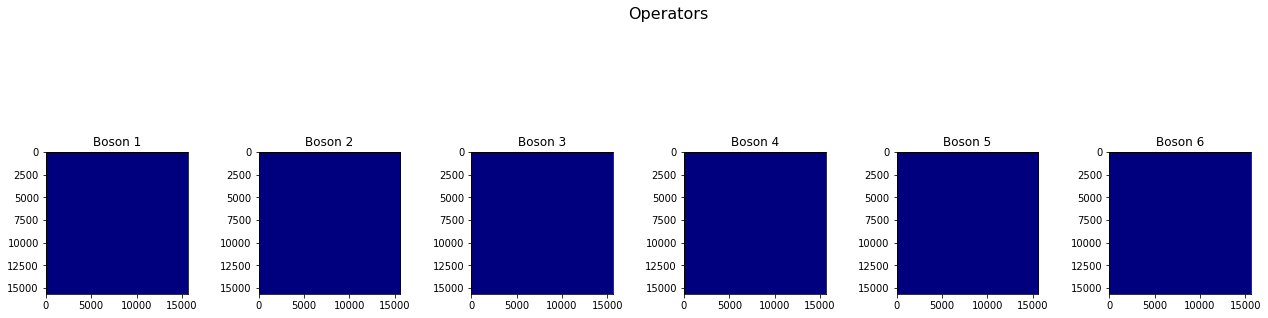

In [9]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(ncols=6, figsize=(18, 6))
fig.subplots_adjust(left=0.02, bottom=0.06, right=0.95, top=0.94, wspace=0.5, hspace=1)
for i,axi in enumerate(np.ravel(ax)):
  pos = axi.imshow(bosonList[i], cmap='jet')
  #fig.colorbar(pos, ax=axi)
  axi.set_title(f"Boson {i+1}")
fig.suptitle('Operators', fontsize=16)
fig.subplots_adjust(top=0.9)

## Creating the Bosons and the Quartic Hamiltonians

The following cell defines a function which creates the bosons, then it creates the simple quartic and full quartic SU2 Hamiltonians. The function recieves the number of bosons and the size of the bosons as arguments. For example, for 6 bosons that are 8x8, the function call would look like bosonHamiltonians(6, 8). The function returns the two Hamiltonians.

First, an annihilation operator and identity matrix is created. Each of the 6 bosons is constructed by taking the Kronecker product of the annihilation operator with the identity matrix, in a specific order. For the $n^{th}$ boson, the annhiliation operator will be in the $n^{th}$ position of the Kronecker product. For example, the first boson's Kronecker product would look like $$\hat{a} \otimes I \otimes I \otimes I \otimes I \otimes I$$ where $\hat{a}$ is the annihilation operator and $I$ is the identity matrix. The 2nd boson would look like $$I \otimes \hat{a} \otimes I \otimes I \otimes I \otimes I$$ and so on.

In [11]:
def bosonHamiltonians(numBosons, bosonMatrixDim, coupling=0.1):
    # This function takes the number of bosons (numBosons) and the size of the bosons (bosonMatrixDim)
    # as arguments. If the size of the boson is 2 x 2, for example, then bosonMatrixDim = 2.
    # coupling is lambda/2 and lambda is the 'tHooft coupling
    
    # Create the n x n annhiliation operator. Here, we create a list with all the integers from
    # the square root of 1 to the square root of n-1, where n x n is the size of the boson.
    # This list is injected as the upper diagonal in an array of zeros.
    annOP = np.array(np.diagflat(np.sqrt(np.linspace(1,bosonMatrixDim-1,bosonMatrixDim-1)),k=1))
    
    # Create the n x n identity matrix.
    iden = np.identity(bosonMatrixDim)
    
    # Create a list which holds the six bosons. bosonList[0] is the first boson. bosonList[5] is the 6th boson.
    # For the first boson, the Kronecker product starts with the annihilation operator.
    bosonList = [annOP]
    
    # This for loop creates the list of bosons before the Kronecker products are taken. The first one was 
    # already created in the previous line.
    for bosons in range(0,numBosons-1):
        bosonList.append(iden)
    
    # This for loop takes the appropriate Kronecker products for each boson.
    for i in range(0,numBosons):
        for j in range(0,numBosons-1):
            
            # For the nth boson, the nth Kronecker product is with the annihilation operator.
            if j == i-1 and i != 0:
                bosonList[i] = np.kron(bosonList[i], annOP)
            # Else, the nth Kronecker product is with the identity matrix.
            else:
                bosonList[i] = np.kron(bosonList[i], iden)

    # Create the position operators. Normalized as in the notes
    x = []
    for r in range(0, numBosons):
        x.append((1/np.sqrt(2))*(bosonList[r] + np.transpose(np.conjugate(bosonList[r]))))
    
    # Create the simple quadratic Hamiltonian.
    H2MM = 0

    for i in range(0,numBosons):
        # The @ symbol is a shorthand for matrix multiplication. It's equivalent to using np.matmul().
        H2MM = H2MM + (np.transpose(np.conjugate(bosonList[i])) @ bosonList[i])

    H2MM = H2MM + 0.5*numBosons*np.identity(bosonMatrixDim**(numBosons))

    # Create the full quartic SU(2) Hamiltonian.
    x_sq = []

    for i in x:
        x_sq.append(i @ i)

    H4MM1 = (H2MM + coupling*((x_sq[2] @ x_sq[3]) 
                              + (x_sq[2] @ x_sq[4]) 
                              + (x_sq[1] @ x_sq[3]) 
                              + (x_sq[1] @ x_sq[5])
                              + (x_sq[0] @ x_sq[4])
                              + (x_sq[0] @ x_sq[5])
                              - 2*((x[0] @ x[2]) @ (x[3] @ x[5]))
                              - 2*((x[0] @ x[1]) @ (x[3] @ x[4]))
                              - 2*((x[1] @ x[2]) @ (x[4] @ x[5]))))
    return H2MM, H4MM1

In [12]:
# Set the number of bosons here. For the proper full quartic SU(2) Hamiltonian, this has to be 6.
numBosons = 6

# Set the size of the bosons here. For an n x n boson, bosonMatrixDim = n.
# 5 will crash Mohammad's laptop -> out of memory > 10GB
# it also crashes this colab with 12Gb of RAM ->  tries 6 of these tcmalloc: large alloc 1953128448 bytes 
# THIS IS ONLY BECAUSE WE ARE USING NUMPY IN THE FUNCTION! THIS CAN BE AVOIDED USING QISKIT OR QUTIP DIRECTLY TO CREATE SPARSE REPRESENTATIONS
bosonMatrixDim = 5

# the function actually creates intermediate matrices x and x2 so the memory footprint is even higher...for N=5 it requires ~50GB of RAM
H2MM, H4MM1 = bosonHamiltonians(numBosons, bosonMatrixDim, coupling=0.1)  # we can change the coupling by adding coupling=0.5 to the args

The cell above takes about 2 minutes to run on Colaboratory with `numboson = 6` and `bosonMatrixDim = 4`

In [13]:
H2MM.shape

(15625, 15625)

In [ ]:
# DO NOT RUN THIS IF matrices are larger than N=2
with np.printoptions(precision=5, suppress=False, linewidth=2000, threshold=sys.maxsize): # print array lines up to character 120 and floats using 3 digits
  print(H4MM1)

In [14]:
# Set the Hamiltonian that you want to run the VQE algorithm with here.
hamiltonian = H4MM1

# Use numpy to find the eigenvalues of the simple quartic Hamiltonian
# this can take a long time for large matrices
val,vec=np.linalg.eig(hamiltonian)
z = np.argsort(val)
z = z[0:len(hamiltonian)]
energies=(val[z])

if hamiltonian.all() == H4MM1.all():
    # Sometimes there are negligible imaginary parts (e.g. order of 10^-16), so I take the real parts only.
    print('Full Quartic SU2 Eigenvalues:\n\n', np.real(energies))
else:
    print('Simple Quartic Eigenvalues:\n\n', energies)
    

Full Quartic SU2 Eigenvalues:

 [ 3.13390803  4.2157739   4.2157739  ... 34.31530823 34.31530823
 34.52382463]


In [17]:
print(np.real(energies[:10]))

[3.13390803 4.2157739  4.2157739  4.2157739  4.2157739  4.2157739
 4.2157739  5.21671795 5.21971636 5.25289552]


## Use QISKIT to solve the problem with quantum algorithms


In [18]:
from qiskit.aqua.algorithms import VQE, NumPyEigensolver, NumPyMinimumEigensolver
import matplotlib.pyplot as plt
import numpy as np
from qiskit import IBMQ, BasicAer, Aer
from qiskit.chemistry import FermionicOperator
from qiskit import IBMQ
from qiskit.ignis.mitigation.measurement import CompleteMeasFitter
from qiskit.providers.aer.noise import NoiseModel
from qiskit.circuit.library import RealAmplitudes
from qiskit.aqua.operators.legacy import WeightedPauliOperator
from qiskit.aqua.operators import (TPBGroupedWeightedPauliOperator,
                                    WeightedPauliOperator,
                                    MatrixOperator)


### Convert the Hamiltonian
Now, we take the Hamiltonian matrix and map it onto a qubit operator. There may be better ways to do this now that `qiskit` has added new ways to map Hamiltonians to qubit operators.

In fact, we should skip the creation of the Hamiltonian as a matrix and directly used operators in `qiskit`

In [19]:
# Convert the Hamiltonian Matrix to a qubit operator.

import warnings
import time

from qiskit.aqua.operators import MatrixOp

start_time = time.time()
warnings.filterwarnings("ignore")

qubitOp = MatrixOp(primitive=hamiltonian)

print("Size of Hamiltonian:", np.shape(hamiltonian))
print(qubitOp)

# The next line shows the pauli string. You can comment it so that the output isn't so messy.
#print(qubitOp.print_details())

# You can print the type of the qubit operator with the next line. This can help when troubleshooting other
# methods of generating the qubit operator.
#print(type(qubitOp))

end_time = time.time()

runtime = end_time-start_time
print('Program runtime: ',runtime)

Size of Hamiltonian: (15625, 15625)
Operator([[ 3.15      +0.j,  0.        +0.j,  0.07071068+0.j, ...,
            0.        +0.j,  0.        +0.j,  0.        +0.j],
          [ 0.        +0.j,  4.25      +0.j,  0.        +0.j, ...,
            0.        +0.j,  0.        +0.j,  0.        +0.j],
          [ 0.07071068+0.j,  0.        +0.j,  5.35      +0.j, ...,
            0.        +0.j,  0.        +0.j,  0.        +0.j],
          ...,
          [ 0.        +0.j,  0.        +0.j,  0.        +0.j, ...,
           27.6       +0.j,  0.        +0.j,  0.69282032+0.j],
          [ 0.        +0.j,  0.        +0.j,  0.        +0.j, ...,
            0.        +0.j, 29.        +0.j,  0.        +0.j],
          [ 0.        +0.j,  0.        +0.j,  0.        +0.j, ...,
            0.69282032+0.j,  0.        +0.j, 29.4       +0.j]],
         input_dims=(15625,), output_dims=(15625,))
Program runtime:  1.4367458820343018


Converting to qubit operators is extremely quick even if the matrix for the Hamiltonian is stored as a full dense matrix of 14GB... The output above seems to indicate that it could not divide the 15625x15625 matrix into smaller subsystems of qubits... This might be simply because there is no integer solution to $\log_2(15625)$

In [21]:
print(qubitOp.num_qubits)

1


In [20]:
print(type(qubitOp))

<class 'qiskit.aqua.operators.primitive_ops.matrix_op.MatrixOp'>


We want to use a Variational Quantum Eigensolver to find the ground state. For this we need to define a variational "circuit" whose parameters will be optimized (with several classical optimizer algorithms) such that the energy expectation value of the final state is minimized.

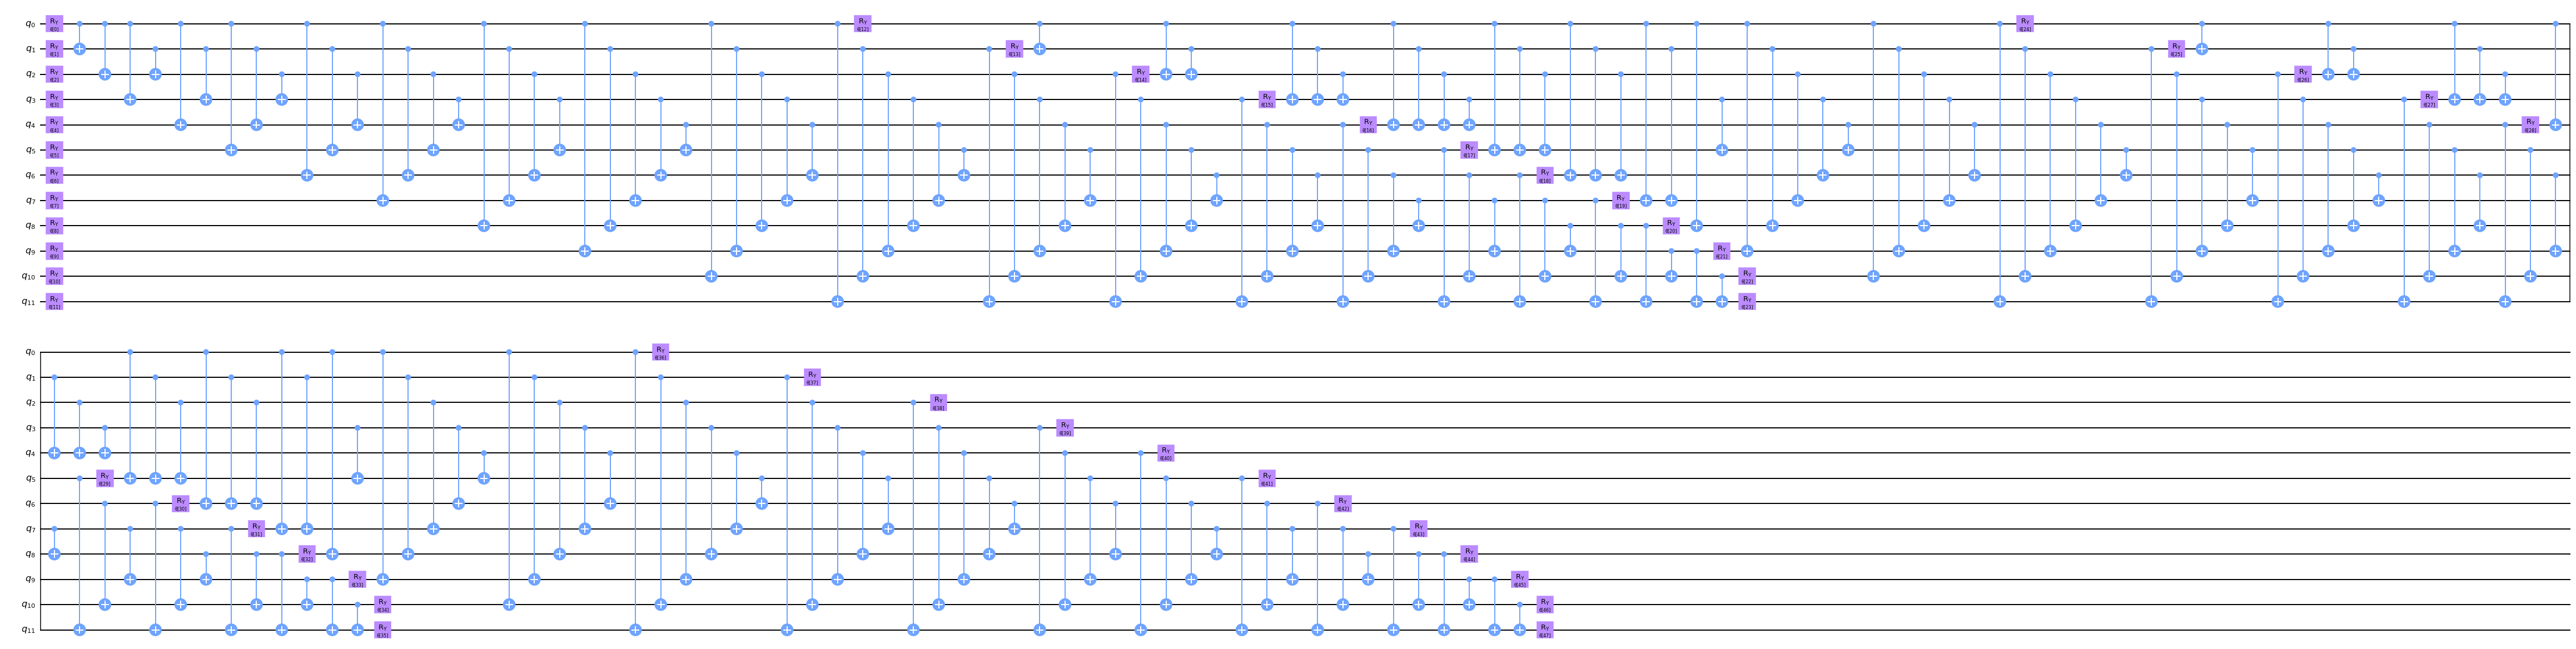

In [20]:
# Create the variational form.
from qiskit.circuit.library import EfficientSU2

var_form = EfficientSU2(qubitOp.num_qubits, su2_gates=['ry'], entanglement="full", reps=3)
display(var_form.draw(output='mpl',fold=100))

In [21]:
print(f"Number of qubits: {qubitOp.num_qubits}")

Number of qubits: 12


The circuit is created using a number of qubits equal to $log_2(N^6)$

In [22]:
np.log2(hamiltonian.shape[0])

12.0

In [ ]:
# Find the exact ground state eigenvalue of the qubit operator. Make sure that this result matches the previous
# ground state eigenvalue of the Hamiltonian above. This makes sure that everything went smoothly when
# converting the Hamiltonian to a qubit operator. 

# NOTE: THIS WILL NOT WORK if qubitOp is a MatrixOp object!

# exact_solution = NumPyEigensolver(qubitOp).run()
# print("Exact Result:", np.real(exact_solution.eigenvalues))

In [23]:
# This is a callback function that will allow us to store information about the optimizer while the VQE is running.
# This is called when instantiating an object of the VQE class.

def store_intermediate_result(eval_count, parameters, mean, std):
    counts.append(eval_count)
    values.append(mean)

## Looping the VQE algorithm over several optimizers

The following cell runs the VQE algorithm multiple times in a for loop, each time with a different optimizer. You can use this to see which optimizer is the best for the Hamiltonian that you're running. For statevector simulators, in my experience, SLSQP is the best optimizer. But as you will see, for these quartic Hamiltonians, sometimes, the COBYLA actually converges the quickest, usually with a slightly more accurate result. If you are only interested in using a single optimizer (since looping the vqe will take substaintially longer run times), you can remove the for loop then replace the optimizer in the VQE class instantiation with any of the elements of the optimizer list (e.g., if you want to run SLSQP, instatiate the VQE class with optimizerList[0]). Note that for QASM simulators or running on real devices, the SPSA optimizer is the best. Also note that sometimes, the optimizers may not converge on the correct result, and you may have to run the vqe algorithm again to see what the result is on average.

#### Statevector simulator

Example from [here](https://qiskit.org/documentation/tutorials/algorithms/02_vqe_convergence.html)

In [24]:
from qiskit.aqua.components.optimizers import SLSQP, COBYLA, L_BFGS_B, NELDER_MEAD

warnings.filterwarnings("ignore")

# use a statevector (no noise) simulator for the quantum hardware
backend = BasicAer.get_backend("statevector_simulator")

countArr = []
valArr = []
vqe_result = []
# the optimizers have individual options that can be set in the init methods
optimizerList = [SLSQP(maxiter=600), COBYLA(maxiter=5000), L_BFGS_B(maxfun=5000, maxiter=20000), NELDER_MEAD(maxfev=5000)]

for optimizer in optimizerList:

  counts = []
  values = []
          
  countArr.append(counts)
  valArr.append(values)
  # measure time for each optimization
  start_time = time.time()

  vqe = VQE(qubitOp, var_form, optimizer, callback=store_intermediate_result)
  ret = vqe.run(backend)
  vqe_result.append(np.real(ret['eigenvalue']))

  end_time = time.time()
  runtime = end_time-start_time
  print(f"{optimizer.print_options()}")
  print(f"Time for VQE: {runtime}s")


print("VQE Result:", vqe_result)


None
Time for VQE: 660.5400967597961s
None
Time for VQE: 1051.0625956058502s
None
Time for VQE: 1054.646332502365s
None
Time for VQE: 1048.8037877082825s
VQE Result: [3.1374241398529437, 3.1371900092093874, 3.1370322695072286, 4.410200948947752]


For a variational circuit with 12 qubits and a depth of 3, it takes about 17 minutes to find convergence with the parameters above.
Some optimizers converge faster than others.

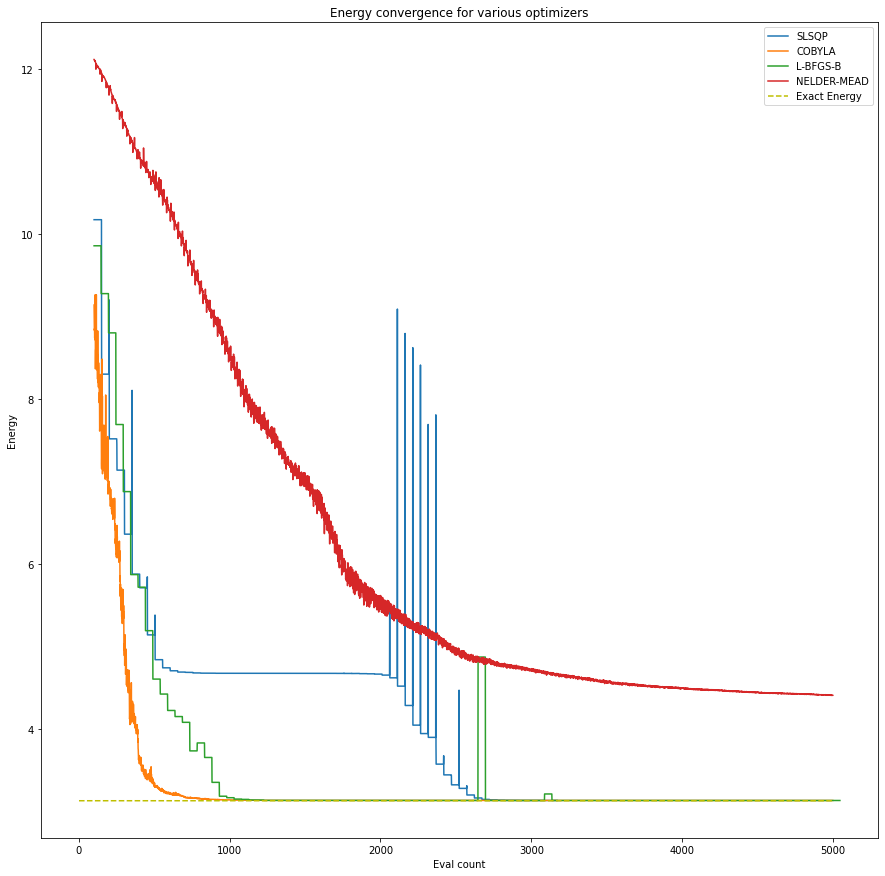

In [25]:
# Plot all of the optimizers in a single convergence plot. If you see that the optimizer isn't converging,
# increase the maximum iterations or maximum function evaluations in the optimizer list above.

labelList = ["SLSQP", "COBYLA", "L-BFGS-B", "NELDER-MEAD"]

plt.figure(figsize=(15,15))

for i in range(0,len(labelList)):
    # Limit the range of the plot in order to make the convergence of each optimizer more visible.
    plt.plot(countArr[i][100:len(countArr[i])-1], valArr[i][100:len(valArr[i])-1], label=labelList[i])

plt.plot(countArr[-1],[np.real(energies[0])]*len(countArr[-1]), 'y--',label="Exact Energy")
plt.xlabel('Eval count')
plt.ylabel('Energy')
plt.title('Energy convergence for various optimizers')
plt.legend(loc='upper right')

#### QASM simulator

Example from [here](https://qiskit.org/documentation/tutorials/algorithms/03_vqe_simulation_with_noise.html#Performance-without-noise)

In [ ]:
from qiskit.aqua.components.optimizers import SPSA
from qiskit.aqua import QuantumInstance


start_time = time.time()
warnings.filterwarnings("ignore")

backendQasm = BasicAer.get_backend('qasm_simulator')
quantum_instance = QuantumInstance(backend=backendQasm, shots=200)
optimizerQasm = SPSA(max_trials=1000)

counts = []
values = []

# Run the VQE
vqe = VQE(qubitOp, var_form, optimizerQasm, callback=store_intermediate_result)
ret = vqe.run(quantum_instance)
vqe_result = np.real(ret['eigenvalue'])
print("VQE Result:", vqe_result)
end_time = time.time()

runtime = end_time-start_time
print('Program runtime:',runtime, "s")

VQE Result: 3.22039949493661
Program runtime: 369.58031153678894 s


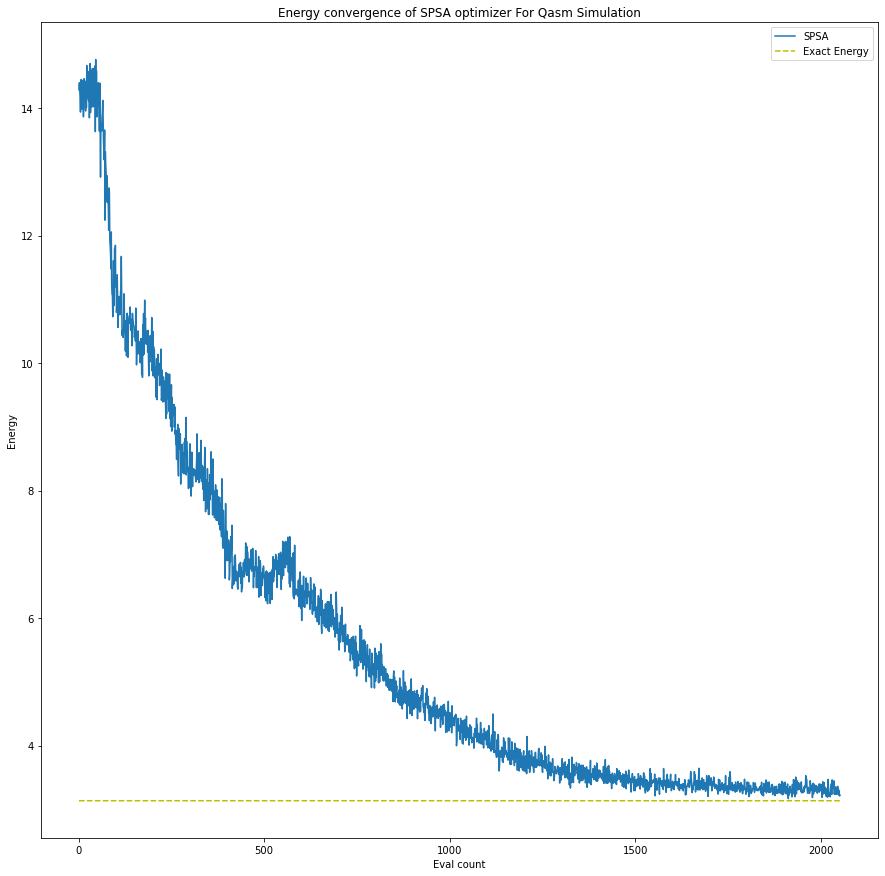

In [ ]:
# Plot convergence plot for the SPSA optimizer
plt.figure(figsize=(15,15))
plt.plot(counts, values, label="SPSA")
plt.plot(counts,[np.real(energies[0])]*len(counts), 'y--',label="Exact Energy")
plt.xlabel('Eval count')
plt.ylabel('Energy')
plt.title('Energy convergence of SPSA optimizer For Qasm Simulation')
plt.legend(loc='upper right')